# Assignment: Analyzing Wikipedia Pages

In this assignment, you will analyze a small fraction of [Wikipedia](https://en.wikipedia.org/wiki/Main_Page) pages. For manipulating Wikipedia pages, you will use `wikipedia` module that could require an installation. You can install the module in several ways, it depends on your installation of python and Jupyter. If you have administrator rights, you can use
``` 
conda install -c conda-forge wikipedia
```
when your installation used `conda` or 
```
pip install wikipedia
```
that should work in any case. However, if you need to install it on a computer where you do not have administrator rights, you should use
```
pip install --user wikipedia
```
which installs the module in a subdirectory of your home directory. 

Official documentation for the `wikipedia` module can be found [here](https://wikipedia.readthedocs.io/en/latest/code.html).

In [1]:
import networkx as nx
import wikipedia

wikipedia.set_lang("en")    # we will search English version of Wikipedia

Module `wikipedia` enables us to load Wikipedia pages and extract links contained within the pages. E.g., let us download the page about the beatle [Bembidion-Ambiguum](https://en.wikipedia.org/wiki/Bembidion_ambiguum) and list all links from the page.

In [2]:
page = "Bembidion-ambiguum"

try:
    wiki = wikipedia.page(page)
except wikipedia.DisambiguationError:
    print("Page title", page,"is ambiguous")
except wikipedia.PageError:
    print("No matching page for '",page,"' found")
    try:
        wiki = wikipedia.page(page,auto_suggest=False)
    except:
        print("No matching page for '",page,"' found even with auto_suggest=False")
    print("auto_suggest=False helped!")
except:
    print("Could not load page",page)

In [3]:
print("The Wikipedia page on '{}' has the title '{}' and contains {} links".format(page,wiki.title,len(wiki.links)))
for link in wiki.links:
    print(link,'|',link.title())

The Wikipedia page on 'Bembidion-ambiguum' has the title 'Bembidion ambiguum' and contains 21 links
Animal | Animal
Arthropod | Arthropod
Beetle | Beetle
Bembidion | Bembidion
Binomial nomenclature | Binomial Nomenclature
California | California
Doi (identifier) | Doi (Identifier)
Eukaryote | Eukaryote
Global Biodiversity Information Facility | Global Biodiversity Information Facility
Ground beetle | Ground Beetle
Insect | Insect
Mediterranean region | Mediterranean Region
PMC (identifier) | Pmc (Identifier)
PMID (identifier) | Pmid (Identifier)
Pierre François Marie Auguste Dejean | Pierre François Marie Auguste Dejean
Salt marsh | Salt Marsh
San Francisco Bay | San Francisco Bay
Taxonomy (biology) | Taxonomy (Biology)
Trechinae | Trechinae
Wikidata | Wikidata
Wikispecies | Wikispecies


Our goal will be to analyze some notion which has a page in Wikipedia and to find important notions related to the given notion. We will do that by building and analyzing the so-called ego network around the given notion.

At first, you should build the ego network, which is a subgraph of nodes that are close to the node representing the given notion. Then you will analyze the network.

Your task is to implement two functions and then use them to analyze given notions.

The first function 
```
getWikipediaNetwork(ego,depth=2)
```
should build a **directed** network of nodes corresponding to the titles of all Wikipedia pages with distance at most `depth` from the starting page `ego`. The distance from page *A* to page *B* is the minimal number of links that should be clicked in order to get from page *A* to page *B*. **Remark:** Your network should contain all nodes of distance at most `depth` from `ego`, but you should collect all edges only for nodes with distance at most `(depth - 1)`.

Your implementation should omit several types of pages that almost always create a dense structure close to virtually each Wikipedia page. You should omit at least all pages with the titles containing suffix "(identifier)" or "(Identifier)". See such pages in the above example.

In [9]:
def get_wiki_page(page):
    try:
        wiki = wikipedia.page(page)
        return wiki
    except wikipedia.DisambiguationError:
        print("Page title", page,"is ambiguous")
    except wikipedia.PageError:
        print("No matching page for '",page,"' found")
        try:
            wiki = wikipedia.page(page,auto_suggest=False)
            print("auto_suggest=False helped!")
            return wiki
        except:
            print("No matching page for '",page,"' found even with auto_suggest=False")
    except:
        print("Could not load page",page) 


def getWikipediaNetwork(ego,depth=2):
    # create network - a directed graph of Wikipedia pages - around the 
    # page with title ego till the distance depth
    id_suffixes = ("(identifier)", "(Identifier)")
    ego_wiki = get_wiki_page(ego)
    wiki_net = nx.DiGraph()
    wiki_net.add_node(ego_wiki.title)
    current_titles = [ego_wiki.title]
    linked_titles = []
    for d in range(depth):
        for page_title in current_titles:
            page = get_wiki_page(page_title)
            if page is not None:
                for link in page.links:
                    if not link.title().endswith(id_suffixes):
                        wiki_net.add_edge(page_title, link.title())
                        linked_titles.append(link.title())
        current_titles = linked_titles
        linked_titles = []
    return wiki_net

#page = "Bembidion-ambiguum"
#print("computing")
#wnet = getWikipediaNetwork(page, depth=2)
#print("drawing")
#nx.draw(wnet,with_labels=False)

    
    
      

Implement the function
```
getNetwork(name,depth=2,download=False)
```

that should create the ego-network (oriented network of type `nx.DiGraph()`)around page with title `name` of depth `depth`. If `download` is `True`, the network should be built by downloading pages from Wikipedia and the built network should be stored in the file with the name 

```
name+'.csv'
```
If `download` is `False`, the function will check whether the file with the name `name+'.csv'` exists. If yes, it supposes that 
the file contains the edge list of the ego network around the notion from the parameter `name`
and returns a network (`nx.DiGraph()`) with the network. Otherwise, it collects the network by calling
the function `getWikipediaNetwork(name,depth)` and stores it in the corresponding CSV-file and returns the network.

In [8]:
import os
#import pandas as pd

def getNetwork(name,depth=2,download=False):
    # create network around the Wikipedia page with title name. If download is False and a file
    # <name>.csv exists, the network is read from the file, otherwise it is built using the function
    # getWikipediaNetwork(name,depth)
    if download:
        print('downloading')
        wnet = getWikipediaNetwork(name, depth)
        nx.write_adjlist(wnet, name+'.csv', delimiter=', ')
    else:
        if os.path.exists(name + '.csv'):
            print('file ', name, '.csv exists. Not downloading.')
            wnet = nx.read_adjlist(name+'.csv', delimiter=', ', 
                   create_using = nx.DiGraph())
        else:
            print('file ', name, '.csv not found -> downloading')
            wnet = getWikipediaNetwork(name, depth)
            nx.write_adjlist(wnet, name+'.csv', delimiter=', ')
    return wnet

Using the above functions (and possibly other suitable functions) implement the function

In [19]:
import numpy as np
import re
import matplotlib.pyplot as plt

def remove_small_deg_nodes(G, min_degree=2):
    degs = sorted(G.degree(), key=lambda x: x[1])
    for n in degs:
        if n[1] < min_degree:
            #print(str(n[1]) + " " + str(n[0]))
            G.remove_node(n[0])
        else:
            break
    return G

def find_top_neighbours(G, ego, topNeighbours=25):
    in_degs = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)
    if len(in_degs) > topNeighbours:
        top_n_nodes = in_degs[:topNeighbours+1] 
    else:
        top_n_nodes = in_degs
    for i, n in enumerate(top_n_nodes):
        #print(n[0], ' does contain ego ', ego, '? ', re.search(ego, n[0], re.IGNORECASE))
        if(re.search(ego, n[0], re.IGNORECASE)):
            top_n_nodes.pop(i)
            break
    if len(top_n_nodes) > topNeighbours:
        top_n_nodes = top_n_nodes[:topNeighbours]
    return top_n_nodes

def analyzeEgo(G,ego,topNeighbours=25):
    print('Original network:')
    print('    number of nodes:', len(G.nodes))
    print('    number of edges:', len(G.edges))
    trunc_G = remove_small_deg_nodes(G)
    print('Truncated network:')
    print('    number of nodes:', len(trunc_G.nodes))
    print('    number of edges:', len(trunc_G.edges))

    print('    ego node: \'', ego, '\' ')
    closeness = nx.closeness_centrality(trunc_G)
    closeness_vals = list(closeness.values())
    print('         closeness centrality:', closeness[ego], ', mean closeness centrality:', np.mean(closeness_vals))
    print(closeness)
    deg_cent = nx.degree_centrality(trunc_G)
    deg_cent_vals = list(deg_cent.values())
    print('         degree centrality:', deg_cent[ego], ', mean: ', np.mean(deg_cent_vals))
    top_n = find_top_neighbours(G,ego,topNeighbours)
    #print(top_n)
    #print(len(top_n))
    top_n_nodes = [n[0] for n in top_n]
    top_n_nodes.append(ego)
    top_n_G = G.subgraph(top_n_nodes)

    pos = nx.spring_layout(top_n_G)

    plt.figure(1, figsize=(15,15))
    nx.draw(top_n_G,with_labels=True, pos=pos, node_size=5000)

    return top_n

In [20]:
#ego = 'Bohemian Paradise'
ego = "Network science"
G = getNetwork(ego)
analyzeEgo(G, ego, 20)

file  Network science .csv exists. Not downloading.
Original network:
    number of nodes: 33560
    number of edges: 77641
Truncated network:
    number of nodes: 10887
    number of edges: 54968
    ego node: ' Network science ' 
         closeness centrality: 0.0 , mean closeness centrality: 0.010722946997858968


TypeError: unhashable type: 'slice'

file  Complex network .csv exists. Not downloading.
Original network:
    number of nodes: 3723
    number of edges: 16209
Truncated network:
    number of nodes: 3723
    number of edges: 16209
    ego node: ' Complex network ' 
         closeness centrality: 0.0 , mean closeness centrality: 0.011858086120710305
         degree centrality: 0.03573347662547018 , mean:  0.0023394664042145903


[('Graph (Discrete Mathematics)', 74),
 ('Vertex (Graph Theory)', 69),
 ('Directed Graph', 63),
 ('Network Theory', 61),
 ('Social Network', 59),
 ('Degree (Graph Theory)', 58),
 ('Adjacency Matrix', 57),
 ('Complete Graph', 55),
 ('Graph Drawing', 55),
 ('Network Science', 55),
 ('Bipartite Graph', 54),
 ('Edge (Graph Theory)', 54),
 ('Cycle (Graph Theory)', 53),
 ('Graph (Abstract Data Type)', 53),
 ('Centrality', 52),
 ('Incidence Matrix', 52),
 ('Path (Graph Theory)', 52),
 ('Scale-Free Network', 52),
 ('Social Capital', 52),
 ('Social Network Analysis Software', 52)]

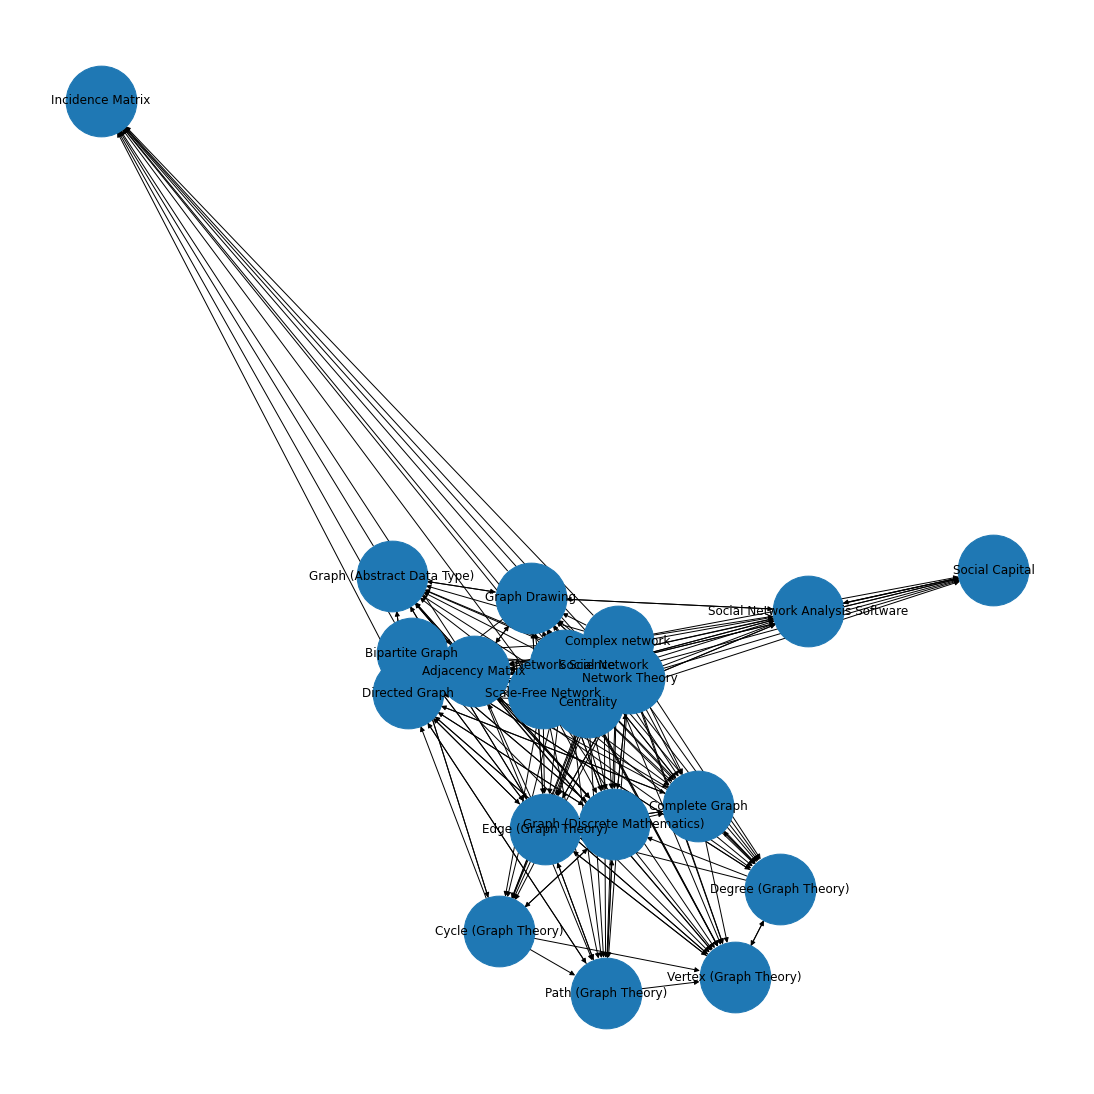

In [89]:
ego = 'Complex network'
G = getNetwork(ego)
analyzeEgo(G, ego, 20)

file  Bohemian Paradise .csv exists. Not downloading.
Original network:
    number of nodes: 396
    number of edges: 992
Truncated network:
    number of nodes: 396
    number of edges: 992
    ego node: ' Bohemian Paradise ' 
         closeness centrality: 0.030464135021097044 , mean closeness centrality: 0.023233033708739113
         degree centrality: 0.07848101265822785 , mean:  0.01268380002557218


[('Czech Republic', 20),
 ('Geographic Coordinate System', 14),
 ('German Language', 9),
 ('Bohemia', 8),
 ('Czech Language', 8),
 ('Districts Of The Czech Republic', 7),
 ('Liberec Region', 7),
 ('Regions Of The Czech Republic', 7),
 ("Thirty Years' War", 7),
 ('Prague', 6),
 ('Turnov', 6),
 ('Central European Summer Time', 6),
 ('Central European Time', 6),
 ('Daylight Saving Time', 6),
 ('Castle', 6),
 ('Germany', 6),
 ('Poland', 6),
 ('Slovakia', 6),
 ('Wayback Machine', 6),
 ('Sandstone', 5)]

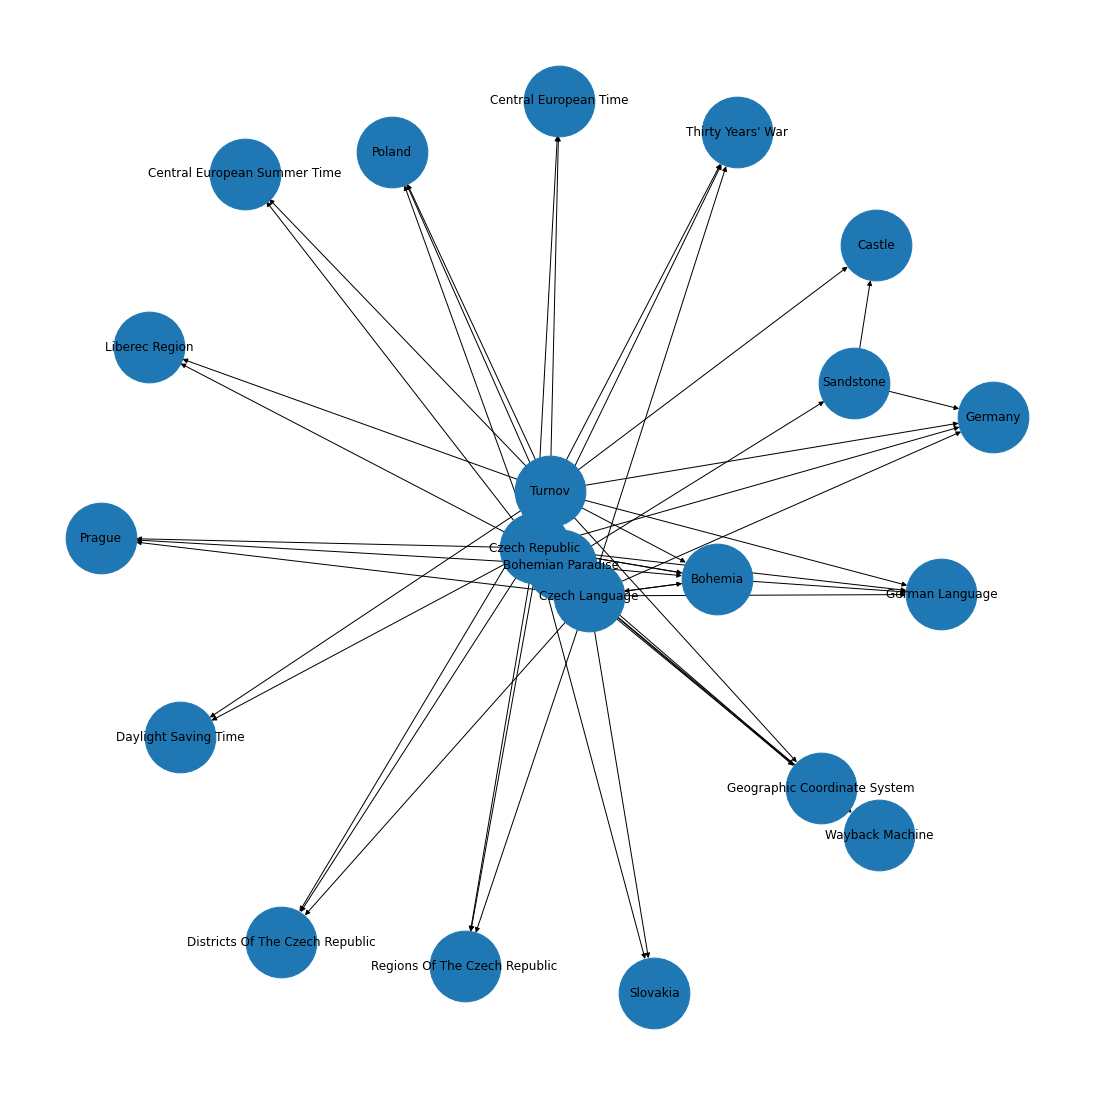

In [90]:
ego = 'Bohemian Paradise'
G = getNetwork(ego)
analyzeEgo(G, ego, 20)

that takes the ego network `G` around node `ego`, deletes all nodes of degree at most one from the network and then finds `topNeighbours` nodes in the network with the highest **in-degree** except the `ego`. The function should  
* print the number of nodes and edges of the original network,
* print the number of nodes and edges of the network after truncation,
* print value of at least two centrality measures for the `ego` node,
* draw the subgraph of `G` on `topNeighbours` nodes with maximal in-degree and the `ego` node,
and 
* return a list of pairs (node,in-degree) for `topNeighbours` nodes with maximal in-degree.

After that, you should use your functions and analyze three ego networks:
1. around `Network science`,
2. around `Complex network` and 
3. around your personal favorite Wikipedia page.
In each of the analyses, you should use and display 20 nodes around ego with the maximal in-degree.

Are the networks comparable?

The networks have many similiar nodes. The network with ego "Complex network" even contains "Network science" as node with in degree 55. Many of these top neighbours are basic graph theory and social network terms.

**Hints:**

* The ego network around `Bembidion-ambiguum` has approximately 8185 nodes and 9763 edges,
the degree of the node Bembidion-ambiguum is 17, its truncated network has 1210 nodes and 2788 edges
* The ego network around `Complex network` has approximately 13830 nodes and 26037 edges,
the degree of the node Complex network is 133, its truncated network has 3504 nodes and 15711 edges.

Your values can differ slightly as the Wikipedia is changing and also some page can be unavailable.

